## See DeepLizard:
    https://deeplizard.com/learn/video/jkdXDinWfo8

# The alogrithme of DQN:

1. Initialize replay memory capacity.
2. Initialize the policy network with random weights.
3. Clone the policy network, and call it the target network.
4. For each episode
    1. Initialize the starting state.
    2. For each time step : 
        1. Select an action :
            - Via exploration or exploitation
        2. Execute selected action in an emulator.
        3. Observe reward and next state.
        4. Store experience in replay memory.
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values.
        9. Requires a pass to the target network for the next state
        10. Gradient descent updates weights in the policy network to minimize loss.
        11. After  time steps, weights in the target network are updated to the weights in the policy network.

# 1) Import:

In [35]:
%matplotlib inline
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  #--------
from collections import namedtuple  #--------
from itertools import count #--------
from PIL import Image #--------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  
from torchsummary import summary
import game

import time
#from IPython.display import clear_output
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: 
    from IPython import display
    print('from IPython, display is imported')
    
    
print('Imported ...')
env = game.ENVIRONMENT()
# while True:
#     env.render()

# while True:
#     state, score, done = env.change_direction(random.randint(0,3))
#     env.render()

from IPython, display is imported
Imported ...


# 2) Define Some Classes:
## 2.1 Define the DQN class:

In [18]:
class DQN(nn.Module):
    def __init__(self, snake_max_len) :
        super().__init__()
        
        self.l1 = nn.Linear(in_features = snake_max_len*3, out_features = 24)
        self.l2 = nn.Linear(in_features =24, out_features = 32)
        self.out= nn.Linear(in_features = 32, out_features = 2)
    
    def forward(self,t):
        t = t.flatten(start_dim = 1)
        t = F.relu(self.l1(t))
        t = F.relu(self.l2(t))
        t = self.out(t)
        
        return t

model = DQN(20*20)#.cuda
#summary(model,(28,28)).cuda
print('finished ...')  

finished ...


## 2.2 Define the experience tuple:

In [19]:
Experience = namedtuple('experience',  ( 'state','action','reward','next_state') )
e = Experience(1,3,3,4)
print(e.state)

1


## 2.3 Replay Memory:
Now that we have our Experience class, let's define our ReplayMemory class, which is where these experiences will be stored.


In [20]:
class replaymemory():
    
    # define the memory parameters:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    # feeding function
    
    def push(self, experience):
        #if self.push_count < self.capacity:
        if len(self.memory) < self.capacity :
            self.memory.append(experience)
        else :
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    # outputting function:
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size 
    
        #print(random.sample(range(10),3))

print('finished ...')  

finished ...


## 2.4 Epsilon Greedy Strategy :

In [21]:
class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay 
        self.history = []
    
    def get_exploration_rate(self, episode):
        rate = self.end + (self.start -self.end )*np.exp(-self.decay*episode)
        self.history.append(rate)
        return rate

print('finished ...')  

finished ...


## 2.5 Reinforcement Learning Agent Class:

In [22]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.num_actions = num_actions
        self.strategy = strategy
        self.current_steps = 0
        self.device = device
        
    # trade off: exploration vs exploitation
    def decide(self, policy_net, state): 
        rate =  self.strategy.get_exploration_rate(self.current_steps)
        self.current_steps += 1 
        
        if rate > random.random(): # explore
            action = random.randrange(self.num_actions)
            action = torch.tensor([action]).to(self.device)
            decision = 'exploration'
            
        else : # otherwise exploite:
            with torch.no_grad(): 
                action = policy_net(state).argmax(dim=1).to(self.device) #policy_net(self.state).argmax(dim=1).item()
            decision = 'exploitation'
                
        return action, decision
    
print('finished ...')  



finished ...


# 3) Define some functions:
## 3.1 Tensor exrators

In [23]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    
#     print('batch.action', batch.action)
#     print('batch.next_state', batch.next_state)
#     print('batch.reward', batch.reward)

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

## 3.2 QValues class

In [24]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current_qvalues(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod        
    def get_next_qvalues(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values    
    
print('finished!')

finished!


## 3.3 PLOT function:

In [25]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

## 3.4 Progression function:

In [26]:
# Progress bar function:
def update_progress(what,i,imax, redraw=False):
    """
    Display a text progress bar, as :
    My progress bar : ############# 34%
    args:
        what  : Progress bas name
        i     : Current progress
        imax  : Max val
        
        #
        ue for i
    return:
        nothing
    """
    bar_length = min(40,imax)
    if (i%int(imax/bar_length))!=0 and i<imax and not redraw:
        return
    progress  = float(i/imax)
    block     = int(round(bar_length * progress))
    endofline = '\r' if progress<1 else '\n'
    text = "{:16s} [{}] {:>5.1f}% of {}".format( what, "#"*block+"-"*(bar_length-block), progress*100, imax)
    print(text, end=endofline)

# 3) Main Program

## 3.1 hyperparameters:

In [27]:
batch_size = 256
gamma = 0.9 # it is the 0.999 that made me crazy :P 
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
net_learning_rate = 0.001
num_episodes = 1000

print('finished ...')

finished ...


## 3.2 Essentiel Objects :

In [28]:
# setup the device :
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the environement manager:
em = game.ENVIRONMENT()

# strategy (exploration rate updater)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

# Agent:
agent = Agent(strategy, em.num_actions, device)

# Memory:
memory = replaymemory(memory_size)

# Target Network and Policy Network:
policy_net = DQN(em.snake_max_len).to(device)
target_net = DQN(em.snake_max_len).to(device)  # target_net =  policy_net
# --
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
# set the optimizer :
optimizer = optim.Adam(params = policy_net.parameters(), lr = net_learning_rate)

print('>>> finished ...')

>>> finished ...


## 3.3 Training Loop :

In [29]:
# array to store episode durations during training in order to plot them using the plot():
episodes_durations = []
#em.get_state()
for episode in range(num_episodes): # 4 for each episode
    state = em.get_state() # A) initialize the starting state
    
    for step in count():#range(20): #count(): # B) for each step:
        # show the progression:
        #print('Episode: ', episode, '| Step: ', step)
        
        action, decision = agent.decide(policy_net,state) # a. let the agetn select an action based on the exploration rate
        #print(action)
        reward = em.step(action) # b. execute the agent selected decision.
        new_state = em.get_state()   # c. observe reward and next state
        experience =  Experience(state, action, reward, new_state)
        memory.push(experience) # d. store the experience in the reaplay memory
        state = new_state # update for the next upcoming step.
        ## Learn from the stored experiences: 
        if memory.can_provide_sample(batch_size) :
            batch =  memory.sample(batch_size)  #  e. Sample random batch from replay memory.
            states, actions, rewards, next_states = extract_tensors(batch) # f...
            
            current_qvalues = QValues.get_current_qvalues(policy_net, states, actions) # g. Pass batch of preprocessed states to POLICY network.
            next_qvalues = QValues.get_next_qvalues(target_net,next_states) # g2. Pass batch of preprocessed states to TARGET network.
            target_qvalues = rewards + gamma*next_qvalues 
            
            loss = F.mse_loss(current_qvalues, target_qvalues.unsqueeze(1)) # h. the loss between target q-values and output q-values 
            optimizer.zero_grad() # i. backpropagation process
            loss.backward()
            optimizer.step()
                

        #display.clear_output(wait=True)
        
        if em.done :
            episodes_durations.append(step)
            plot(episodes_durations,100)
            break
        
        # show the state:
        #show_state(episode, step, em)
        #update_progress('Episodes: ', episode , num_episodes)
        
    if episode % target_update == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()
        
print('>>> finished ...')
#print(len(memory.memory))

AttributeError: 'ENVIRONMENT' object has no attribute 'get_state'

10939


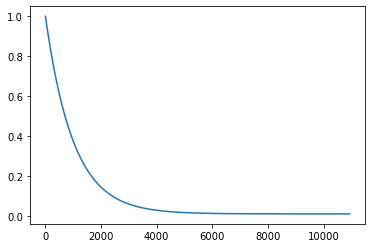

In [53]:
print(agent.current_steps)
plt.plot(strategy.history)

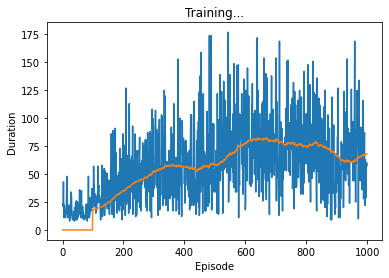

Episode 1000 
 100 episode moving avg: 67.92


In [23]:
plot(episodes_durations,100)
